# **Scraping ESPN NBA data**

In [1]:
import os  # For operating system related functionality
import json  # For working with JSON data
from datetime import datetime  # For working with dates and times
from tqdm import tqdm  # For displaying progress bars
import pandas as pd  # For working with dataframes
import numpy as np  # For working with arrays
from bs4 import BeautifulSoup  # For web scraping
import requests  # For making HTTP requests
import re  # For regular expressions

def get_soup(url):
    """
    Returns a BeautifulSoup object for the given URL.
    """
    page = requests.get(url, headers={'User-agent': 'your bot 0.1'})
    soup = BeautifulSoup(page.text, 'html.parser')
    return soup

# Constant for base URL
base_url = 'https://www.espn.com/'

## 1. Get the list of teams

In [2]:
def get_teams_df():
    # return teams dataframe if exists or scrape and save to parquet
    if os.path.exists('data/teams.parquet'):
        return pd.read_parquet('data/teams.parquet')

    url = 'https://www.espn.com/nba/teams'
    soup = get_soup(url)

    team_data = []
    for team in soup.find_all('section', class_='TeamLinks flex items-center'):
        team_data.append({
            'name': team.find('a').find('img')['alt'],
            'tag': team.find('a')['href'].split('/')[-1],
            'code': team.find('a')['href'].split('/')[-2],
            'url': team.find('a')['href']
        })

    teams_df = pd.DataFrame(team_data)
    # save to parquet
    teams_df.to_parquet('data/teams.parquet')

    return teams_df

get_teams_df().head()

,name,tag,code,url,bref_url,bref_code
0,Atlanta Hawks,atlanta-hawks,atl,/nba/team/_/name/atl/atlanta-hawks,/teams/ATL/2023.html,ATL
1,Boston Celtics,boston-celtics,bos,/nba/team/_/name/bos/boston-celtics,/teams/BOS/2023.html,BOS
2,Brooklyn Nets,brooklyn-nets,bkn,/nba/team/_/name/bkn/brooklyn-nets,/teams/BRK/2023.html,BRK
3,Charlotte Hornets,charlotte-hornets,cha,/nba/team/_/name/cha/charlotte-hornets,/teams/CHO/2023.html,CHO
4,Chicago Bulls,chicago-bulls,chi,/nba/team/_/name/chi/chicago-bulls,/teams/CHI/2023.html,CHI


## 2. Get the schedule for a single team

In [3]:
def get_schedule(team_code: str, team_tag: str, year: int = 2023) -> list:
    """Get schedule for a team in a given year
    Args:
        team_code (str): 3 letter team code. Example: 'atl'
        team_tag (str): team tag. Example: 'atlanta-hawks'
        year (int, optional): year. Example: 2023 means 2022-2023 season.
    Returns:
        list: list of dictionaries with schedule data
    """

    url = f'https://www.espn.com/nba/team/schedule/_/name/{team_code}/season/{year}/seasontype/2'
    soup = get_soup(url)
    game_list = soup.find('table').find_all('tr')[1:]
    schedule_data = []
    for game in game_list:
        tds = game.find_all('td')
        schedule_data.append({
            # datetime.strptime('Wed, Oct 19', '%a, %b %d')
            'date': tds[0].text,
            'datetime': datetime.strptime(tds[0].text, '%a, %b %d'),
            'is_home': tds[1].text.split(' ')[0] == 'vs',
            'result': tds[2].text[0],
            'scores': tds[2].text[1:].strip().split(' ')[0].split('-'),
            'OT': tds[2].text.strip()[-1] == 'T',
            'game_url': tds[2].find('a')['href'].split('.com/')[1] if tds[2].find('a') else None,
            'schedule_of': team_tag,
            'openent': tds[1].find('a')['href'].split('/')[-1],
        })
    return schedule_data

In [4]:
def transform_schedule(schedule_data):
    df = pd.DataFrame(schedule_data)
    df['datetime'] = df['datetime'].apply(lambda x: x.replace(year=2022) if x.month >= 10 else x.replace(year=2023))
    return df

transform_schedule(get_schedule('atl', 'atlanta-hawks')).head()

,date,datetime,is_home,result,scores,OT,game_url,schedule_of,openent
0,"Wed, Oct 19",2022-10-19,True,W,"[117, 107]",False,nba/game/_/gameId/401468020,atlanta-hawks,houston-rockets
1,"Fri, Oct 21",2022-10-21,True,W,"[108, 98]",False,nba/game/_/gameId/401468175,atlanta-hawks,orlando-magic
2,"Sun, Oct 23",2022-10-23,True,L,"[126, 109]",False,nba/game/_/gameId/401468193,atlanta-hawks,charlotte-hornets
3,"Wed, Oct 26",2022-10-26,False,W,"[118, 113]",False,nba/game/_/gameId/401468212,atlanta-hawks,detroit-pistons
4,"Fri, Oct 28",2022-10-28,False,W,"[136, 112]",False,nba/game/_/gameId/401468225,atlanta-hawks,detroit-pistons


## 3. Get the schedule for all teams

In [5]:
def get_schedule_df(year: int = 2023) -> pd.DataFrame:
    if os.path.exists('data/schedule.parquet'):
        return pd.read_parquet('data/schedule.parquet')

    # get the schedule for each team
    schedule_data = []
    for index, row in tqdm(team_df.iterrows(), total=team_df.shape[0]):
        schedule_data.extend(get_schedule(row['code'], row['tag'], year))
        
    schedule_df = pd.DataFrame(schedule_data)
    schedule_df['datetime'] = schedule_df['datetime'].apply(lambda x: x.replace(year=2022) if x.month >= 10 else x.replace(year=2023))

    # Drop the away games
    schedule_df = schedule_df[schedule_df['is_home'] == True]

    # Save home and away scores
    schedule_df['home_score'] = schedule_df.apply(lambda x: x['scores'][0] if x['result'] == 'W' else x['scores'][-1], axis=1)
    schedule_df['away_score'] = schedule_df.apply(lambda x: x['scores'][-1] if x['result'] == 'W' else x['scores'][0], axis=1)

    # Drop unnecessary columns
    schedule_df = schedule_df.drop(columns=['is_home', 'date', 'scores'])

    # Rename columns
    schedule_df.columns = ['date', 'home_win', 'OT', 'url', 'home_team', 'away_team', 'home_score', 'away_score']

    # Drop rows with duplicate urls (caused by neutral site games)
    schedule_df.drop_duplicates(subset=['url'], inplace=True)

    # Drop rows with nans
    schedule_df.dropna(inplace=True)

    # Check that there are 30 teams and 82 games per team
    assert schedule_df.shape[0] == 30 * 82 / 2
    
    # Save to parquet
    schedule_df.to_parquet('data/schedule.parquet')

    return schedule_df

get_schedule_df().head()

,date,home_win,OT,url,home_team,away_team,home_score,away_score
0,2022-10-18,W,False,nba/game/_/gameId/401468016,boston-celtics,philadelphia-76ers,126,117
4,2022-10-28,L,True,nba/game/_/gameId/401468227,boston-celtics,cleveland-cavaliers,123,132
5,2022-10-30,W,False,nba/game/_/gameId/401468244,boston-celtics,washington-wizards,112,94
7,2022-11-04,W,False,nba/game/_/gameId/401468279,boston-celtics,chicago-bulls,123,119
10,2022-11-09,W,False,nba/game/_/gameId/401468318,boston-celtics,detroit-pistons,128,112


## 4. List of players per team

In [6]:
def get_bref_teams(year: int = 2023) -> pd.DataFrame:
    if os.path.exists('data/bref_teams.parquet'):
        return pd.read_parquet('data/bref_teams.parquet')

    soup = get_soup(f'https://www.basketball-reference.com/leagues/NBA_{year}_standings.html')
    all_tables = soup.find_all('table')
    print(len(all_tables))
    bref_teams = []
    for table in all_tables[:2]:
        for team in table.find_all('a'):
            bref_teams.append({
                'name': team.text,
                'bref_url': team['href'],
                'bref_code': team['href'].split('/')[-2],
            })
    bref_teams_df = pd.DataFrame(bref_teams)
    bref_teams_df.to_parquet('data/bref_teams.parquet')
    return bref_teams_df

In [7]:
def fix_teams_df(check=False):
    "Run if teams_df doesn't have bref columns"
    if check:
        teams_df = get_teams_df()
        bref_teams_df = get_bref_teams()

        teams_df = teams_df.sort_values('name').reset_index(drop=True)
        teams_df.loc[teams_df['name'] == 'LA Clippers', 'name'] = 'Los Angeles Clippers'
        teams_df.loc[teams_df['name'] == 'LA Clippers', 'tag'] = 'los-angeles-clippers'
        teams_df = teams_df.merge(bref_teams_df, left_on='name', right_on='name', how='outer')
        teams_df.to_parquet('data/teams.parquet')
    else:
        print('Set check=True to run this function. Check whether teams_df has bref columns.')

fix_teams_df()

Set check=True to run this function. Check whether teams_df has bref columns.


In [8]:
def get_players_df(year: int = 2023) -> pd.DataFrame:
    if os.path.exists('data/players.pkl'):
        return pd.read_pickle('data/players.pkl')
    
    teams_df = get_teams_df()
    players = []
    for team_code in tqdm(teams_df['bref_code']):
        roster = pd.read_html(f'https://www.basketball-reference.com/teams/{team_code.upper()}/{year}.html')[0]
        roster.rename(columns={'Unnamed: 6': 'Origin'}, inplace=True)
        roster['bref_code'] = team_code
        players.extend(roster.values.tolist())

    players_df = pd.DataFrame(players)
    players_df.columns = ['Number', 'Name', 'Pos', 'Height', 'Weight', 'Birth Date', 'Origin', 'Exp', 'College', 'bref_code']

    players_df.to_pickle('data/players.pkl')
    return players_df

get_players_df().head()

,Number,Name,Pos,Height,Weight,Birth Date,Origin,Exp,College,bref_code
0,41,Saddiq Bey,SF,6-7,215,"April 9, 1999",us,2,Villanova,ATL
1,13,Bogdan Bogdanović,SG,6-6,220,"August 18, 1992",rs,5,NaN,ATL
2,15,Clint Capela,C,6-10,240,"May 18, 1994",ch,8,NaN,ATL
3,20,John Collins,PF,6-9,235,"September 23, 1997",us,5,Wake Forest,ATL
4,7,Jarrett Culver,SF,6-6,195,"February 20, 1999",us,3,Texas Tech,ATL


## 5. Get the "play-by-play" for a single game

In [9]:
schedule_df = get_schedule_df()

# Example game url. Click on the url to see the game details :)
print(f'The game we are going to work on is {schedule_df.iloc[-1]["home_team"]} vs {schedule_df.iloc[-1]["away_team"]}')
url = 'nba/game/_/gameId/401361018'
print(f'URL: {base_url}{url}')

The game we are going to work on is san-antonio-spurs vs minnesota-timberwolves
URL: https://www.espn.com/nba/game/_/gameId/401361018


In [10]:
# You access play-by-play by changing '/game/' to '/playbyplay/' in the url
print(f'The play-by-play url is:')
print(f'{base_url}{url.replace("/game/", "/playbyplay/")}')

The play-by-play url is:
https://www.espn.com/nba/playbyplay/_/gameId/401361018


In [47]:
def get_playbyplay(game_url: str):
    """Gets play-by-play data for a given game url.
    Args:
        game_url (str): url of the game. Example: '/nba/game/_/gameId/401267260'"""

    soup = get_soup(base_url + game_url.replace('/game/', '/playbyplay/'))
    
    # A weird ass script tag that has all the data
    text = soup.find_all('script')[-5].text
    text = text.split('playGrps')[1].split('}]],')[0] + '}]]'
    data = json.loads(text[2:])

    # flatten list
    df = pd.DataFrame([item for sublist in data for item in sublist]) 
    # columns are [id, period, text, homeAway, awayScore, homeScore, clock, scoringPlay]
    
    df['id']          = df['id'].astype(int)
    df['period']      = df['period'].apply(lambda x: x['number'])
    df['text']        = df['text'].fillna('').astype(str)
    df['homeAway']    = df['homeAway'].fillna('neutral').astype('category')
    df['clock']       = df['clock'].apply(lambda x: x['displayValue']).astype(str)
    df['scoringPlay'] = df['scoringPlay'].fillna(False)

    return df

playbyplay_df = get_playbyplay(url)
playbyplay_df.head()

,id,period,text,homeAway,awayScore,homeScore,clock,scoringPlay
0,4013610184,1,Jakob Poeltl vs. Karl-Anthony Towns (Tre Jones...,away,0,0,12:00,False
1,4013610187,1,Devin Vassell misses 14-foot pullup jump shot,away,0,0,11:39,False
2,4013610188,1,Patrick Beverley defensive rebound,home,0,0,11:36,False
3,4013610189,1,Anthony Edwards makes driving layup,home,0,2,11:24,True
4,40136101810,1,Jakob Poeltl misses two point shot,away,0,2,11:08,False


In [48]:
def gameclock2seconds(period, minutes, seconds):
    return (period - 1) * 12 * 60 + (11 - minutes) * 60 + (60 - seconds)

def secondsPassed(row):
    if len(row['clock'].split(':')) == 2:
        minutes, seconds = (int(x) for x in row['clock'].split(':'))
    elif len(row['clock'].split(':')) == 1:
        minutes = 0
        seconds = int(row['clock'].split('.')[0])

    return gameclock2seconds(row['period'], minutes, seconds)

playbyplay_df['secondsPassed'] = playbyplay_df.apply(secondsPassed, axis=1)
playbyplay_df['FT'] = playbyplay_df['text'].str.contains('free throw')

In [49]:
def add_player_names(playbyplay_df, team_tags):
    """
    Adds a column with player names to the playbyplay_df.
    Args:
        playbyplay_df (pd.DataFrame): playbyplay dataframe
        team_tags (list): list of team tags. Example: ['atlanta-hawks', 'charlotte-hornets']
    """
    players_df = get_players_df()
    teams_df = get_teams_df()

    # Get the set of players that played in the teams
    player_set = set(players_df.loc[players_df['bref_code'].isin(teams_df.loc[teams_df['tag'].isin(team_tags), 'bref_code']), 'Name'])

    # Add a column with the player names
    playbyplay_df['playerNames'] = playbyplay_df['text'].apply(lambda x: [name for name in player_set if name in x])

    # Sort the names by their position in the text
    playbyplay_df['playerNames'] = playbyplay_df.apply(lambda x: [name for name, _ in 
                    sorted([(name, re.search(name, x['text']).start()) for name in x['playerNames']], key=lambda x: x[1])], axis=1)

    return playbyplay_df

playbyplay_df = add_player_names(playbyplay_df, schedule_df.loc[2460, ['home_team', 'away_team']])
playbyplay_df.head()

,id,period,text,homeAway,awayScore,homeScore,clock,scoringPlay,secondsPassed,FT,playerNames
0,4013610184,1,Jakob Poeltl vs. Karl-Anthony Towns (Tre Jones...,away,0,0,12:00,False,0,False,"[Jakob Poeltl, Karl-Anthony Towns, Tre Jones]"
1,4013610187,1,Devin Vassell misses 14-foot pullup jump shot,away,0,0,11:39,False,21,False,[Devin Vassell]
2,4013610188,1,Patrick Beverley defensive rebound,home,0,0,11:36,False,24,False,[]
3,4013610189,1,Anthony Edwards makes driving layup,home,0,2,11:24,True,36,False,[Anthony Edwards]
4,40136101810,1,Jakob Poeltl misses two point shot,away,0,2,11:08,False,52,False,[Jakob Poeltl]


## 6. Finding the play in the video
We are going to look at the last game of the year.

I have dowloaded this video [Spurs @ Timberwolves](https://basketball-video.com/san-antonio-spurs-vs-minnesota-timberwolves-full-game-replay-apr-7-2021-nba-replay-hd). It also says it is broadcasted on local TV: BSN, BSSW-SA:
* BSN stands for Bally Sports North
* BSSW-SA stands for Bally Sports Southwest - San Antonio

Here's the [list of NBA broadcasters by Wikipedia](https://en.wikipedia.org/wiki/List_of_current_National_Basketball_Association_broadcasters)

In [14]:
# !pip install opencv-python
import cv2
import random
from IPython.display import display, Image
from PIL import Image as ImagePIL
import pytesseract 

def display_image(image):
    _, img_encoded = cv2.imencode('.png', image)
    display(Image(data=img_encoded))



**ALSO INSTALL TESSERACT ON YOUR MACHINE**
- For Mac: brew install tesseract
- For Windows: https://stackoverflow.com/questions/50951955/pytesseract-tesseractnotfound-error-tesseract-is-not-installed-or-its-not-i

Video path videos/spurs@timberwolves.mp4

Total frames: 280556, Frame number: 56111


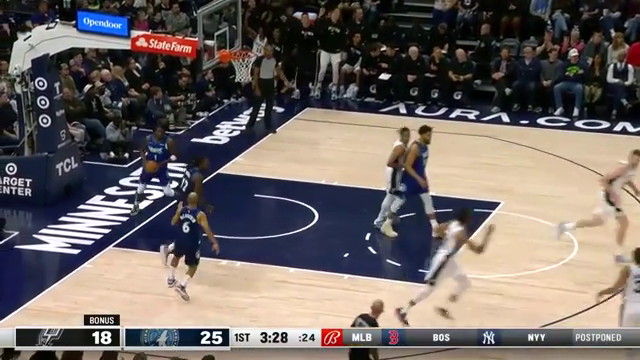

In [15]:
# Read video
vidcap = cv2.VideoCapture('videos/spurs@timberwolves.mp4')

# Get total number of frames
total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

# I selected the denomonator 5 so that we can see the scoreboard.
frame_number = total_frames // 5
print(f'Total frames: {total_frames}, Frame number: {frame_number}')

# Set frame number
vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Read frame and display
success, image = vidcap.read()
display_image(image)

In [16]:
# Read frame
success, image = vidcap.read()
print(f'Height is {image.shape[0]}, cropping between 91% and 96%')
image = image[int(image.shape[0] * 0.91):int(image.shape[0] * 0.96)]

# Display frame
display_image(image)

print(f'Width is {image.shape[1]}, cropping between 36% and 50%')
image = image[:, int(image.shape[1] * 0.36):int(image.shape[1] * 0.5)]

# Display frame
display_image(image)

Height is 360, cropping between 91% and 96%


Width is 640, cropping between 36% and 50%


In [17]:
def ocr(image):
    whitelist_chars = '0123456789 :STNDRDTHO'
    return pytesseract.image_to_string(ImagePIL.fromarray(image), lang='eng', config=f'--psm 7 --oem 3 -c tessedit_char_whitelist="{whitelist_chars}"')

In [18]:
print(f'OCR on the cropped image: {ocr(image)}')
import numpy as np
# Display frame
if success:
    _, img_encoded = cv2.imencode('.png', image)
    display(Image(data=img_encoded))

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(f'Applied grayscale, previous shape: {image.shape}, new grayscale shape: {gray.shape}')
print(f'OCR on the cropped image: {ocr(gray)}')

# Display frame
if success:
    _, img_encoded = cv2.imencode('.png', gray)
    display(Image(data=img_encoded))

# Apply thresholding
thresh = cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY)[1]

print('Applied thresholding, OCR: ', ocr(thresh))

# Display frame
if success:
    _, img_encoded = cv2.imencode('.png', thresh)
    display(Image(data=img_encoded))

OCR on the cropped image: 1ST 3:28 :24



Applied grayscale, previous shape: (18, 90, 3), new grayscale shape: (18, 90)
OCR on the cropped image: 1ST 3:28 :24



Applied thresholding, OCR:  1ST 3:28 :24



## 7. Finding the play in the video

In [26]:
def get_game_time(image: np.ndarray, check_grayscale: bool = False, verbose: bool = False):
    """Returns the game time from the scoreboard image. The format is (period, minutes, seconds)."""

    image = image[int(image.shape[0] * 0.91):int(image.shape[0] * 0.96), # Crop top and bottom
                  int(image.shape[1] * 0.36):int(image.shape[1] * 0.5)]  # Crop left and right
    # grayscale
    gt = ocr(image).strip().split()

    if len(gt) != 3 and len(gt) != 2:
        print(f'Error: Could not read game time (list length is not 3 or 2) {gt}') if verbose else None
        print(gt) if verbose else None
        return -1
    
    try:
        if gt[0] == 'ST':
            period = 1
        else:
            period = int(gt[0][0])

        if gt[1][0] == ':': # this is when 0 minutes remaining only seconds are shown
            minutes = 0
            seconds = int(gt[1][1:3])
        else:
            minutes = int(gt[1].split(':')[0])
            seconds = int(gt[1].split(':')[1])
    except:
        # print('Length of gt is 3 or 2 but could not convert to int')
        # print(gt)
        return -1
    
    return period, minutes, seconds

In [27]:
# Read video
vidcap = cv2.VideoCapture('videos/spurs@timberwolves.mp4')

# Test everthing again
frame_number = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT)) // 5

# Set frame number
vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Game time
_, image = vidcap.read()
print(f'Game time: {get_game_time(image)}')
del vidcap, frame_number

Game time: (1, 3, 28)


To search for a play given the **game time** and **period**,
1. we will randomly select a frame,
2. we will try to read the time and period from the frame,
3. if the time and period is readable, we will update the left and right bounds of the frame,
4. if it is not readable, we will try another frame.

In [53]:
anthony_edwards_plays = playbyplay_df.loc[playbyplay_df['text'].apply(lambda x: 
                                            'Anthony Edwards' == x[:len('Anthony Edwards')]) &  # Anthony Edwards plays
                                            (playbyplay_df['scoringPlay'] | playbyplay_df['FT']) &            # Scoring plays
                                            (playbyplay_df['period'] <= 4)                      # First 4 quarters
                                          ].copy()

anthony_edwards_plays['secondsPassed'] -= 1
print(f'Number of plays: {anthony_edwards_plays.shape[0]}')
anthony_edwards_plays['frame'] = -1
anthony_edwards_plays.reset_index(drop=True, inplace=True)
anthony_edwards_plays.head()

Number of plays: 30


,id,period,text,homeAway,awayScore,homeScore,clock,scoringPlay,secondsPassed,FT,playerNames,frame
0,4013610189,1,Anthony Edwards makes driving layup,home,0,2,11:24,True,35,False,[Anthony Edwards],-1
1,40136101813,1,Anthony Edwards makes 6-foot two point shot,home,0,4,10:42,True,77,False,[Anthony Edwards],-1
2,40136101848,1,Anthony Edwards makes driving layup,home,4,8,8:12,True,227,False,[Anthony Edwards],-1
3,40136101856,1,Anthony Edwards makes step back jumpshot (Jarr...,home,6,14,7:18,True,281,False,[Anthony Edwards],-1
4,401361018110,1,Anthony Edwards makes two point shot (Jordan M...,home,17,21,4:17,True,462,False,"[Anthony Edwards, Jordan McLaughlin]",-1


In [29]:
def get_left_right_frames(s: int, search_df: pd.DataFrame) -> tuple:
    """Get the left and right frames for the target second"""
    return search_df.loc[search_df['secondsPassed'] <= s, 'frame'].max(), search_df.loc[search_df['secondsPassed'] >= s, 'frame'].min()
    
def find_random_game_frame(vidcap, l_frame, r_frame, verbose: bool = True):
    """Find a random frame in the game, where the game clock is visible"""
    gt = -1; iters = 0
    while gt == -1:
        # Randomly select a frame
        frame_number = random.randint(l_frame, r_frame)

        # Set frame number
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

        # Read frame
        _, image = vidcap.read()

        # Get game time. If not found, the function returns -1
        gt = get_game_time(image)
        iters += 1

    played_secs = gameclock2seconds(*gt)

    return gt, frame_number, played_secs, iters

def find_frame(vidcap, search_df, l_frame, r_frame, target_played_seconds, maxiter: int = 100, verbose: bool = True):

    # Initialize the left and right frames
    played_secs = -299
    frame_number = -1
    total_iters = 0
    while played_secs != target_played_seconds:

        if verbose:
            print(f'Left frame: {l_frame}, Right frame: {r_frame}')

        gt, frame_number, played_secs, iters = find_random_game_frame(vidcap, l_frame, r_frame, verbose=False)
        data = {
            'frame': frame_number,
            'secondsPassed': played_secs,
            'gametime': gt
        }

        # search_df = search_df.append(data, ignore_index=True)
        search_df = pd.concat([search_df, pd.DataFrame([data])])
        search_df.sort_values(['secondsPassed', 'frame'], inplace=True, ignore_index=True)
        
        # drop false values
        search_df = search_df[search_df['frame'].diff().fillna(1).gt(0)]

        # get left and right frames
        l_frame, r_frame = get_left_right_frames(target_played_seconds, search_df)

        total_iters += iters
        if total_iters > maxiter:
            print(f'Error: Could not find the frame in {maxiter} iterations')
            return -1, search_df
    
    return frame_number, search_df, total_iters

Here, below I found it useful to manually tell where the quarters start. If not, it gets lost in the commercials. The problem case is when a play happens in the beginning of the quarter.

In [30]:
# Surpress FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Read video
vidcap = cv2.VideoCapture('videos/spurs@timberwolves.mp4')

# Video properties
fps = vidcap.get(cv2.CAP_PROP_FPS)
total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

# TODO: I'm giving some information manually, but this should be extracted from the video
search_df = pd.DataFrame([{'frame': 10*60*fps,        'secondsPassed': 0,       'gametime': (1, 12, 0)},
                          {'frame': 44*60*fps,        'secondsPassed': 12*60,   'gametime': (2, 12, 0)},
                          {'frame': 88*60*fps,        'secondsPassed': 2*12*60, 'gametime': (3, 12, 0)},
                          {'frame': total_frames - 1, 'secondsPassed': 4*12*60, 'gametime': (4, 0,  0)}],
                          dtype=int)

In [55]:
for index, row in (pbar := tqdm(anthony_edwards_plays.iterrows(), total=anthony_edwards_plays.shape[0])):
    
    target_sec = row['secondsPassed']
    l_frame, r_frame = get_left_right_frames(target_sec, search_df)
    
    target_frame, search_df, total_iters = find_frame(vidcap, search_df, l_frame, r_frame, target_sec, verbose=False)
    anthony_edwards_plays.loc[index, 'frame'] = target_frame
    
    pbar.set_description(f'Target seconds: {target_sec}, frame size {int(r_frame - l_frame)}, total iters: {total_iters}, size/iter: {int((r_frame - l_frame) / total_iters)}')

Target seconds: 2870, frame size 0, total iters: 1, size/iter: 0: 100%|██████████| 30/30 [00:09<00:00,  3.27it/s]


In [59]:
def match_frames(search_df, plays_df):
    for idx, play in plays_df.iterrows():
        #print(search_df.loc[search_df['secondsPassed'] == play['secondsPassed'], 'frame'].sort_values().values)
        plays_df.loc[idx, 'frame'] = search_df.loc[search_df['secondsPassed'] == play['secondsPassed'], 'frame'].sort_values().values[0]

match_frames(search_df, anthony_edwards_plays)
len(set(anthony_edwards_plays['frame']))

22

### *Free Throws*
They are quite a problem because the game clock stops, so we can't learn much from them to find the exact frame where the free throw is used. Luckiliy, if the FT is made, we can look at the scoreboard.

In [120]:
freethrows = anthony_edwards_plays.loc[anthony_edwards_plays['FT']].copy().reset_index(drop=True)
freethrows['made'] = freethrows['text'].str.contains('makes')
freethrows['faul_frame'] = freethrows['frame']
freethrows.tail()

,id,period,text,homeAway,awayScore,homeScore,clock,scoringPlay,secondsPassed,FT,playerNames,frame,made,faul_frame
9,401361018657,4,Anthony Edwards makes free throw 2 of 2,home,106,119,4:25,True,2614,True,[Anthony Edwards],249368,True,249368
10,401361018690,4,Anthony Edwards misses free throw 1 of 2,home,111,122,1:36,False,2783,True,[Anthony Edwards],260544,False,260544
11,401361018697,4,Anthony Edwards makes free throw 2 of 2,home,111,123,1:36,True,2783,True,[Anthony Edwards],260544,True,260544
12,401361018722,4,Anthony Edwards makes free throw 1 of 2,home,119,124,9.1,True,2870,True,[Anthony Edwards],267568,True,267568
13,401361018725,4,Anthony Edwards makes free throw 2 of 2,home,119,125,9.1,True,2870,True,[Anthony Edwards],267568,True,267568


In [118]:
def ocr_score(image, t: float = 0.916, b: float = 0.963, l: float = 0.29, r: float = 0.355):
    whitelist_chars = '0123456789'
    s = pytesseract.image_to_string(
        ImagePIL.fromarray(image[int(t*image.shape[0]):int(b*image.shape[0]), int(l*image.shape[1]):int(r*image.shape[1])]), 
        lang='eng', config=f'--psm 7 --oem 3 -c tessedit_char_whitelist="{whitelist_chars}"').strip()
    try:
        return int(s)
    except ValueError:
        return None

success, image = vidcap.read()
ocr_score(image)

123

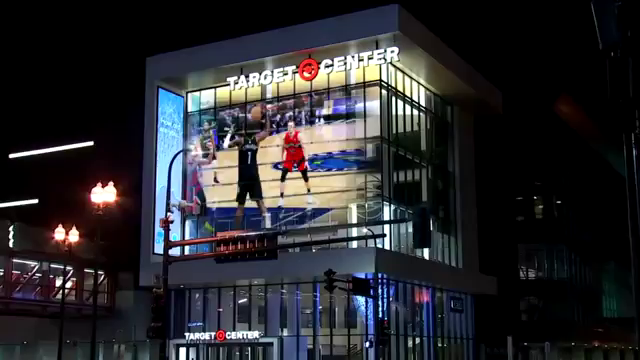

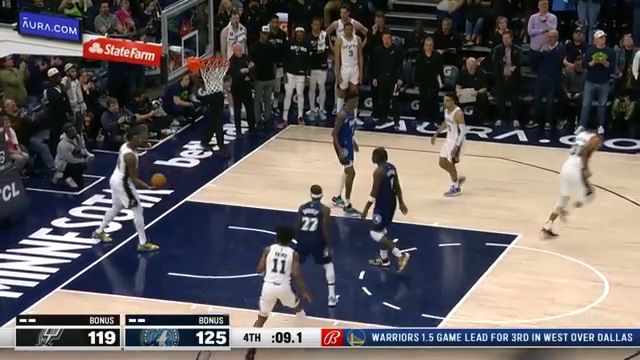

In [124]:
# Read video
vidcap = cv2.VideoCapture('videos/spurs@timberwolves.mp4')

# Example free throw frame
frame = freethrows.loc[13, 'frame']



# Read frame and display
_, image = vidcap.read()
display_image(image)

score = -1; i = 0

while score != freethrows.loc[13, 'homeScore']:
    # Set frame number
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, freethrows.loc[13, 'faul_frame'] + i*fps)

    # Read frame and display
    _, image = vidcap.read()
    
    # Get score
    score = ocr_score(image)
    i += 1

display_image(image)

def correc_ft_frame(freethrow_df, vidcap, fps):
    """
    Corrects the frame number for each free throw
    """
    for i in range(len(freethrow_df)):
        # Get frame
        frame = freethrow_df.loc[i, 'frame']

        # Read frame and display
        _, image = vidcap.read()

        # Get score
        score = ocr_score(image)

        # Get difference
        diff = score - freethrow_df.loc[i, 'homeScore']

        # Correct frame
        freethrow_df.loc[i, 'faul_frame'] = frame + diff*fps

    return freethrow_df

In [ ]:
# TODO: continue in freethrows

## **8. Exporting Videos**

In [36]:
from moviepy.editor import VideoFileClip
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

# Get the fps of the video
fps = vidcap.get(cv2.CAP_PROP_FPS)
print(f'Frames per second: {fps}')

# Set the duration in seconds
l_pad = 5
r_pad = 2

# Set the start and end time
start_time = anthony_edwards_plays.loc[0, 'frame'] / fps

ffmpeg_extract_subclip("videos/spurs@timberwolves.mp4", start_time - l_pad, start_time + r_pad, targetname="test.mp4")

Frames per second: 30.0
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


### Merging videos by without exporting subclips

In [43]:
from moviepy.editor import VideoFileClip, concatenate_videoclips

video = VideoFileClip("videos/spurs@timberwolves.mp4")

clip = concatenate_videoclips([video.subclip(frame / fps - l_pad, frame / fps + r_pad) for frame in sorted(set(anthony_edwards_plays['frame']))], method="compose")

# Save the final clip
clip.write_videofile('videos/final.mp4', codec="libx264")

# Close the clips to free up resources
clip.close()
video.close()

Moviepy - Building video videos/final.mp4.
MoviePy - Writing audio in finalTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video videos/final.mp4



Moviepy - Done !
Moviepy - video ready videos/final.mp4
